从零实现线性回归

1.初始化

In [31]:
import random 
import torch 
from d2l import torch as d2l
import numpy

2.导入数据集

In [32]:
#生成数据函数 torch.normal是生成正态分布的（mean，vias，（数量，维度））
def synthetic_data(w,b,num_examples):
    x = torch.normal(0,1,(num_examples,len(w)))
    y= torch.matmul(x,w)+b
    y += torch.normal(0,0.01,y.shape)
    return x,y.reshape((-1,1))
#这里的reshape是重构，-1表示未指定，1列就是最内层是1

true_w = torch.tensor([2,-3.4])
true_b = 4.2 
features,labels = synthetic_data(true_w,true_b,1000)

In [33]:
print('faetures:',features[0],'\nlabels:',labels[0])

faetures: tensor([-0.4245,  0.1762]) 
labels: tensor([2.7380])


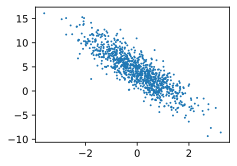

In [34]:
d2l.set_figsize()
#这里绘制，以特征x作为横坐标，生成的y为纵坐标，显示出呈现线性相关的散点图
d2l.plt.scatter(features[:,1].detach().numpy(),
                labels.detach().numpy(),1)


In [35]:
def data_iter(batch_size,features,labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    #将样本的坐标进行一个打乱
    random.shuffle(indices)
    for i in range(0,num_examples,batch_size):
    #以butch_size作为间隔来读取
        batch_indices = torch.tensor(indices[i:min(i+batch_size,num_examples)])
        #生成一个批次的张量坐标
        yield features[batch_indices],labels[batch_indices]
        #yield返回这个张量坐标对应的批量features和labels，返回的是一个可迭代的对线

batch_size = 10

for x,y in data_iter(batch_size,features,labels):
    print(x,'\n',y)
    

tensor([[ 0.9558, -0.0678],
        [-1.2610,  1.5507],
        [-1.1891,  0.3100],
        [-2.2872,  0.8473],
        [ 1.6359, -1.5084],
        [-0.3405,  2.0175],
        [-0.0693, -0.4237],
        [ 1.3248, -2.0646],
        [-0.9729, -0.5192],
        [ 0.0695,  0.4451]]) 
 tensor([[ 6.3415],
        [-3.5771],
        [ 0.7640],
        [-3.2466],
        [12.5881],
        [-3.3329],
        [ 5.5110],
        [13.8941],
        [ 4.0262],
        [ 2.8304]])


在调用生成器函数的过程中，每次遇到 yield 时函数会暂停并保存当前所有的运行信息（保留局部变量），返回yield的值, 并在下一次执行next()方法时从当前位置继续运行，直到生成器被全部遍历完。

3.定义模型：

In [36]:
w = torch.normal(0,0.01,size = (2,1),requires_grad=True)
b = torch.zeros(1,requires_grad=True)

def linreg(x,w,b):
    """线性回归模型"""
    return torch.matmul(x,w) + b 

def squared_loss(y_hat,y):
    """均方损失函数"""
    return (y_hat - y.reshape(y_hat.shape))**2/2

def sgd(params,lr,batch_size):
    """小批量随机梯度下降优化器"""
    with torch.no_grad(): #注意这里更新的时候，用之前的梯度，这里不需要额外计算
        for param in params:
            param -= lr * param.grad/batch_size
            param.grad.zero_()#不仅不用计算，还给他归零，因为pytorch他不会自动的清零
            
        

4.训练过程：这里的学习率是可调参数，很有意思

In [46]:

lr = 0.03
num_epochs = 3 #
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for x,y in data_iter(batch_size,features,labels):
        #第一步，算损失
        l = loss(net(x,w,b),y)
        #第二步，算梯度
        l.sum().backward()
        #第三步：梯度下降
        sgd([w,b],lr,batch_size)
    with torch.no_grad():
        train_l = loss(net(features,w,b),labels)
        print(f'epoch {epoch+1},loss {float(train_l.mean()):f}')

epoch 1,loss 0.000053
epoch 2,loss 0.000053
epoch 3,loss 0.000053


In [47]:
#进行一个误差的审视
print(f'w的估计误差 {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差 {true_b - b}')

w的估计误差 tensor([ 3.8266e-05, -6.0010e-04], grad_fn=<SubBackward0>)
b的估计误差 tensor([0.0001], grad_fn=<RsubBackward1>)
